In [186]:
import numpy as np
import numpy
from sklearn.datasets import fetch_openml
def fetch_mnist():
#     Download MNIST dataset
    X, y = fetch_openml('Fashion-MNIST', version=1, return_X_y=True)
    X = np.array(X)
    y = np.array(y)
    print(y)
#     Randomly sample 7000 images
    np.random.seed(2)
    indices = np.random.choice(len(X), 700, replace=False)
    X, y = X[indices], y[indices]
    return X, y
X, y = fetch_mnist()

['9' '0' '0' ... '8' '1' '5']


In [187]:
idx2class={'0': 'T-shirt/top', '1': 'Trouser', '2': 'Pullover', '3': 'Dress', '4': 'Coat', '5': 'Sandal', '6': 'Shirt', '7': 'Sneaker',
'8': 'Bag', '9': 'Ankle'}

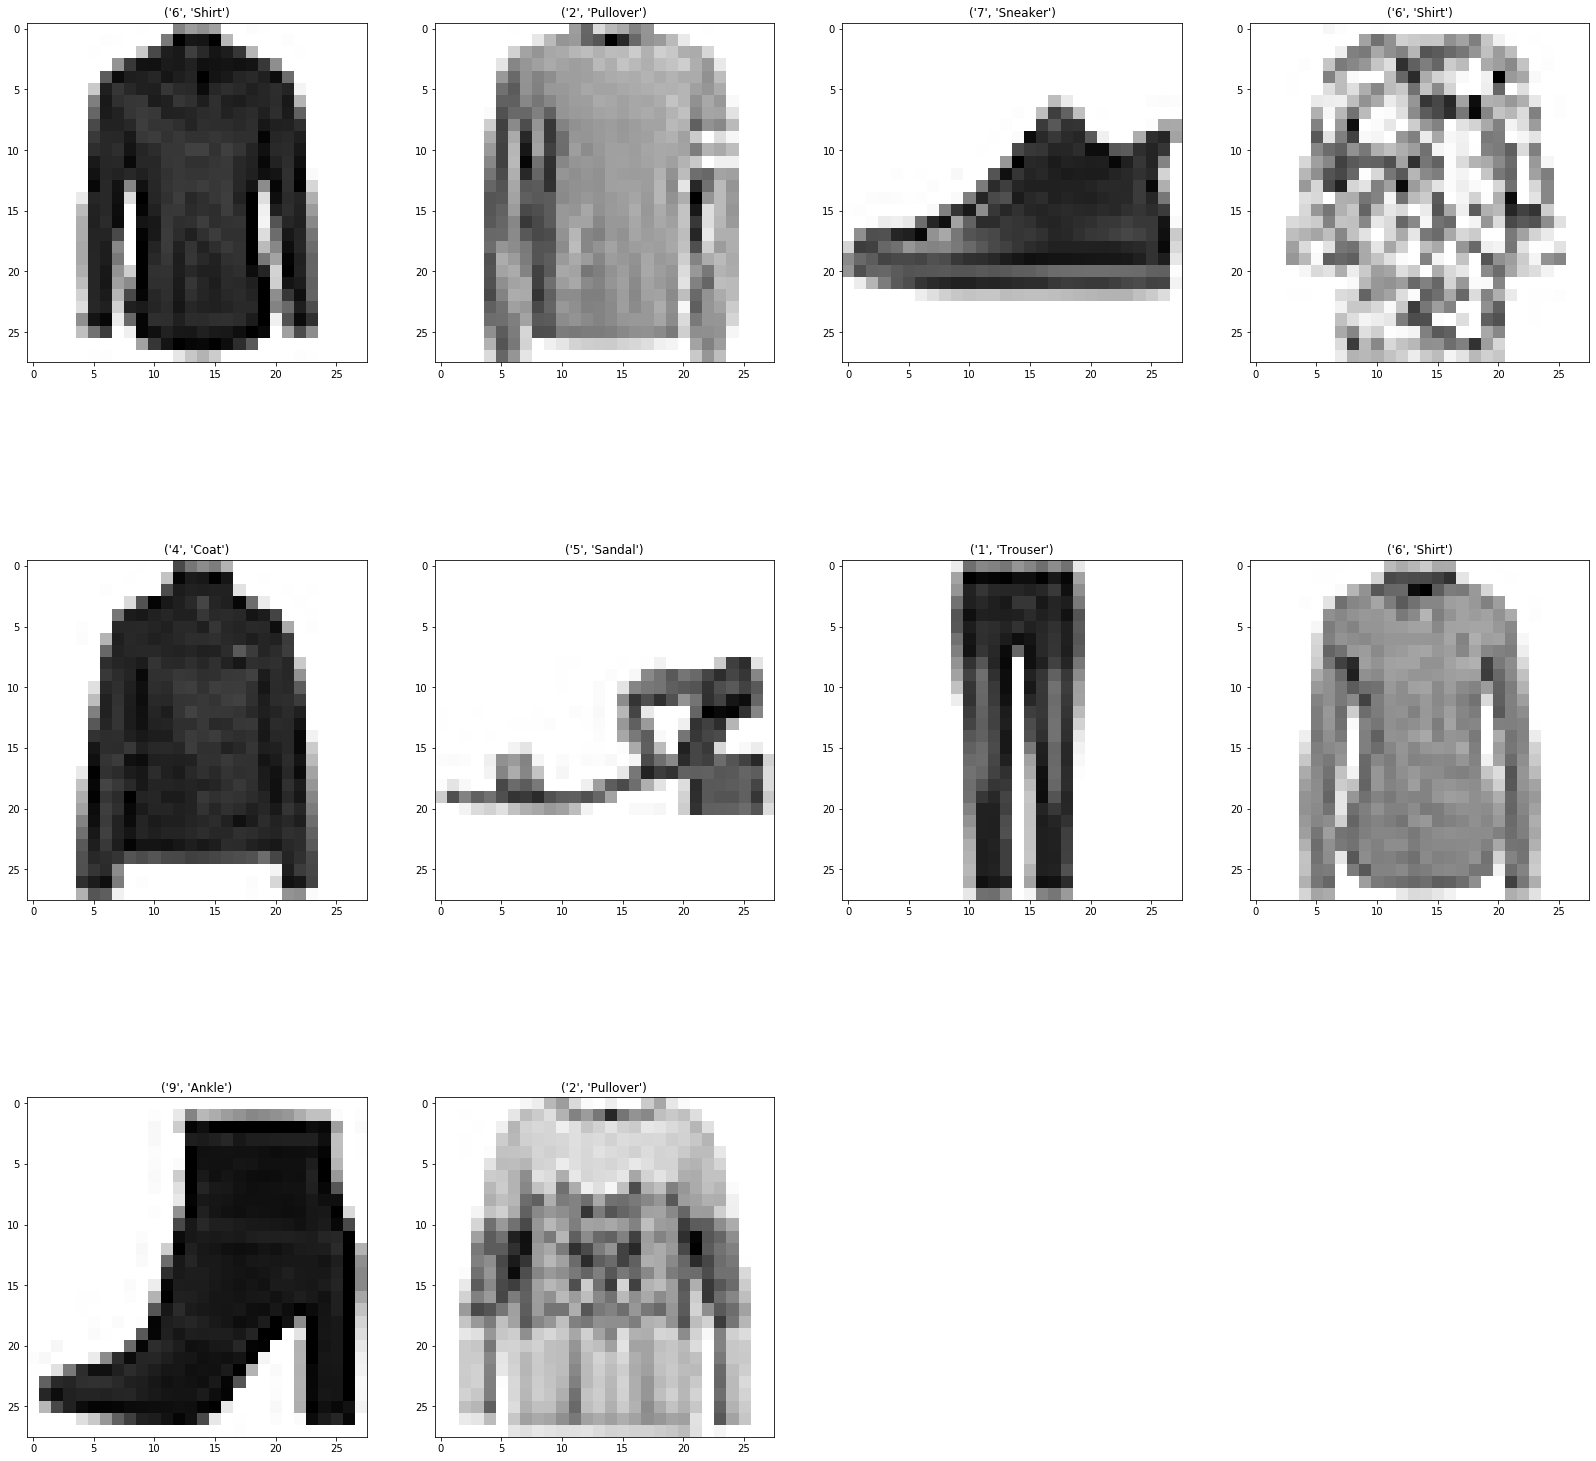

In [188]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(3,4, figsize = (28,28))
fig.delaxes(axes[2,2])
fig.delaxes(axes[2,3])
# fig.subplots_adjust(wspace = 1)
for i in range(10):
    ax = axes[i//4, i%4]
    point = X[i].reshape(28,28)
    ax.imshow(point, cmap = "binary")
    ax.set_title((y[i],idx2class[y[i]]))

In [225]:
import numpy as np
def create(data_set,typeData):
    if typeData == "train":
         X_folds = [data_set[0][0]]
         for fold in data_set:
             for point in fold:
                     X_folds = np.concatenate((X_folds, [point]), axis = 0)
    else:
        X_folds = [data_set[0]]
        for point in data_set:
                X_folds = np.concatenate((X_folds, [point]), axis = 0)
    return X_folds[:,:X_folds.shape[1]-1], X_folds[:,X_folds.shape[1]-1]

In [231]:
def cross_validation_error(X,y,model,folds):
     # Create folds
     folds_list = []
     y_copy = np.array([y])
     X_with_labels = np.concatenate((X,y_copy.T), axis = 1)
     shuffled = X_with_labels
     np.random.shuffle(shuffled)
     fold_size = round(X.shape[0] / folds)
     train_errors_lst = []
     test_errors_lst = []
     average_train_error = 0
     average_test_error = 0
     splited= np.array_split(shuffled, 4)
     for out_fold_index in range(folds):
         # Create train/test
         test_set = splited[out_fold_index]
         train_set = []
         for inner_index in range(folds):
             if inner_index != out_fold_index:
                 train_set.append(splited[inner_index])
         # build train and test matrices of x and vectors of labels
         X_train_folds,y_train_folds = create(train_set,"train")
         X_val,y_val = create(test_set,"test")

         # train error
         model.fit(X_train_folds, y_train_folds)
         y_pred = model.predict(X_train_folds)
         train_error = (np.sum(y_train_folds != y_pred))/X_train_folds.shape[0]
         train_errors_lst.append(train_error)
         average_train_error += train_error
         # test error
         y_pred = model.predict(X_val)
         val_error = (np.sum(y_val != y_pred))/X_val.shape[0]
         test_errors_lst.append(val_error)
         average_test_error += val_error
     average_train_error /= folds
     average_test_error /= folds

     return average_train_error, average_test_error

In [240]:
from sklearn.svm import SVC
def svm_results(X_train, y_train, X_test, y_test):
    folds = 4
    dictRes = {}
    for model_of_SVC in ['linear', 'poly', 'rbf']:
        if model_of_SVC == 'linear':
             model = SVC(kernel = model_of_SVC)
             average_train_error, average_val_error = cross_validation_error(X_train,y_train, model,folds)
             model.fit(X_train,y_train)
             y_pred = model.predict(X_test)
             test_error = (np.sum(y_test != y_pred))/X_test.shape[0]
             label = model_of_SVC
             dictRes[label] = (average_train_error, average_val_error, test_error)
        else:
            if model_of_SVC == 'poly':
                 for d in [2,4,6,8]:
                     model = SVC(kernel = model_of_SVC, degree = d)
                     average_train_error, average_val_error = cross_validation_error(X_train,y_train, model,folds)
                     model.fit(X_train,y_train)
                     y_pred = model.predict(X_test)
                     test_error = (np.sum(y_test != y_pred))/X_test.shape[0]
                     label = model_of_SVC + "_" + str(d) 
                     dictRes[label] = (average_train_error, average_val_error, test_error)
            else:
                 for gamma_val in [0.001, 0.01, 0.1, 1, 10]:
                     model = SVC(kernel = model_of_SVC, gamma = gamma_val)
                     average_train_error, average_val_error = cross_validation_error(X_train,y_train, model,folds)
                     model.fit(X_train,y_train)
                     y_pred = model.predict(X_test)
                     test_error = (np.sum(y_test != y_pred))/X_test.shape[0]
                     label = model_of_SVC + "_" + str(gamma_val)
                     dictRes[label] = (average_train_error, average_val_error, test_error)
    return dictRes

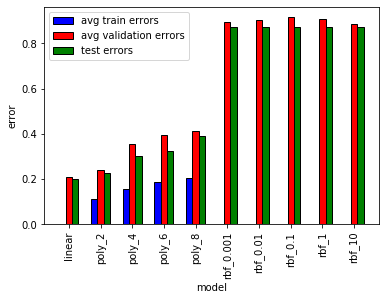

In [243]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.25, random_state=42)
dictRes = svm_results(X_train, y_train, X_test, y_test)
# plot errors bar plot
barWidth = 0.2
x_dots = ["linear", "poly_2", "poly_4", "poly_6", "poly_8", "rbf_0.001", "rbf_0.01", "rbf_0.1", "rbf_1","rbf_10"]
bar = np.arange(len(x_dots))
avg_train_errors = []
avg_val_errors = []
test_errors = []

for key in dictRes.keys():
    avg_train_errors.append(dictRes[key][0])
    avg_val_errors.append(dictRes[key][1])
    test_errors.append(dictRes[key][2])
plt.bar(bar-0.2, avg_train_errors, label = "avg train errors", color = "blue", width = barWidth, edgecolor ='black',align = 'center')
plt.bar(bar, avg_val_errors, label = "avg validation errors", color = "red", width = barWidth, edgecolor ='black',align = 'center')
plt.bar(bar+0.2, test_errors, label = "test errors", color = "green", width = barWidth, edgecolor ='black',align = 'center')
plt.xlabel("model")
plt.ylabel("error")
plt.xticks(bar,x_dots, rotation=90)
plt.legend()
plt.show()

The best model according to the cv method is a polynomial with degree 2, it can be seen from the plot that this method computes the best results both for the test and for the training of all the tested methods